In [ ]:
from common_configs import (
    resnet50_grapher12_conv_gelu_config,
)
from common.train_pipeline.model.model import get_model


model = get_model(resnet50_grapher12_conv_gelu_config())
# print(model)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

# To watch nvidia-smi continuously after every 2 seconds: watch -n 2 nvidia-smi

In [ ]:
BATCH_SIZE = 20
EPOCHS = 20

In [ ]:
from common.data_pipeline.mmcbnu.dataset import DatasetLoader as mmcbnu
from common.data_pipeline.fvusm.dataset import DatasetLoader as fvusm
from common.util.data_pipeline.dataset_chainer import DatasetChainer
from common.util.enums import EnvironmentType

environment = EnvironmentType.PYTORCH
datasets = DatasetChainer(
    datasets=[
        mmcbnu(included_portion=1, environment_type=environment),
        fvusm(included_portion=0, environment_type=environment),
    ]
)
train, test, validation = datasets.get_dataset(environment, batch_size=BATCH_SIZE)

In [ ]:
for image, labels in train:
    print(model(image.float()).shape)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
torch.save(model, "models/resnet50_pretrained.pt")

In [ ]:
model = torch.load(f"models/resnet50_pretrained.pt").to(device)

In [ ]:
from common.train_pipeline.model.isotropic_vig import isotropic_vig_ti_224_gelu

model = isotropic_vig_ti_224_gelu()
model.to(device)
print()
# print(model)

In [ ]:
with torch.no_grad():
    for inputs, labels in train:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        print(inputs.shape)
        x = model.conv1(inputs)
        print(x.shape)
        x = model.bn1(x)
        print(x.shape)
        x = model.relu(x)
        print(x.shape)
        x = model.maxpool(x)
        print(x.shape)
        x = model.layer1(x)
        print(x.shape)
        x = model.layer2(x)
        print(x.shape)
        x = model.layer3(x)
        print(x.shape)
        x = model.layer4(x)
        print(x.shape)
        break

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
jsd = None
mixup_active = None

train_loss_fn = nn.CrossEntropyLoss().cuda()
validate_loss_fn = nn.CrossEntropyLoss().cuda()

# Training loop
for epoch in range(EPOCHS):
    # model.train()
    with torch.no_grad():
        for inputs, labels in tqdm(train, desc=f"Epoch {epoch}: "):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = train_loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            outputs = model(inputs)
            val_loss += validate_loss_fn(outputs, labels)
            predicted = (outputs == outputs.max()).float()
            total += labels.size(0)

            correct += (predicted & labels).sum().item()

    print(
        f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Accuracy: {(correct/total)*100:.2f}%"
    )
model.train()

(100, 300) <class 'numpy.ndarray'>


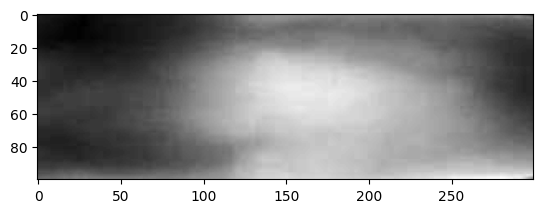

(100, 300)


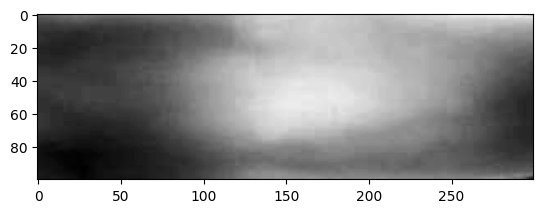

In [66]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np


image_path = "G:/finger-vein-quality-assessement/datasets/FV-USM/1st_session/extractedvein/vein001_1/01.jpg"
# image_path = "./datasets/MMCBNU_6000/ROIs/084/L_Fore/02.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image.shape[0] > image.shape[1]:
    image = image.transpose()
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.InvertImg(p=0.05),
        A.PixelDropout(p=0.1),
    ]
)
transformed = transform(image=image)
transformed_image = transformed["image"]
print(image.shape, type(image))
plt.imshow(image, cmap="gray")
plt.show()
res_img = transformed_image
print(res_img.shape)
plt.imshow(np.asarray(res_img), cmap="gray")
plt.show()

In [ ]:
image_rgb = np.stack([image, image, image], axis=2)
print(image_rgb.shape)
plt.imshow(image_rgb)

In [ ]:
from common.train_pipeline.backbone.backbone import get_backbone
from common.train_pipeline.config import ModelConfig

config = ModelConfig()
print(get_backbone(config))